Downloading Data from kaggle

In [2]:
#  Uncomment those lines and Upload kaggle.json after generating API token from kaggle website using your account
# ! chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Mounting your Drive

In [3]:
from google.colab import drive
drive.mount('content')

Mounted at content


In [56]:
# Check path validity
# import os
# os.listdir("/content/content/MyDrive/Master/Deep learning/Tensor flow/Deep Learning Master Class with Tensor flow2/Section12/Emotions Dataset/Emotions Dataset/train")

In [57]:
# Uncooment this to unzip the data
# !unzip "content/My Drive/Master/Deep learning/Tensor flow/Deep Learning Master Class with Tensor flow2/Section12/human-emotions-datasethes.zip" -d "content/My Drive/Master/Deep learning/Tensor flow/Deep Learning Master Class with Tensor flow2/Section12/"


In [12]:
train_directory = "/content/content/MyDrive/Master/Deep learning/Tensor flow/Deep Learning Master Class with Tensor flow2/Section12/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/content/MyDrive/Master/Deep learning/Tensor flow/Deep Learning Master Class with Tensor flow2/Section12/Emotions Dataset/Emotions Dataset/test"


In [ ]:
import tensorflow as tf
import numpy as np

In [11]:
### math computations
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy

In [128]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.2,
    "REGULARIZATION_RATE": 0.0001,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

# Data Management

## Dataset Loading

In [21]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [29]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [43]:
# Take a look on the batch labels
# Change label_mode to int and run it again to see what happen
# Change batch size and run it again to see what happen
# Remove .shape at lines 6,7,8 and see what happen
for i in train_dataset.take(1):
  print(f"Train Batche images looks like {i[0].shape}")
  print(f"\n Train Batch labels looks like {i[1].shape}")
  print(f"\n One sample in Batch one looks like {i[0][0].shape}")
  print(f"\n One label in Batch one looks like {i[1][0]}")

Train Batche images looks like (32, 256, 256, 3)

 Train Batch labels looks like (32, 3)

 One sample in Batch one looks like (256, 256, 3)

 One label in Batch one looks like [0. 1. 0.]


## Dataset Visualization

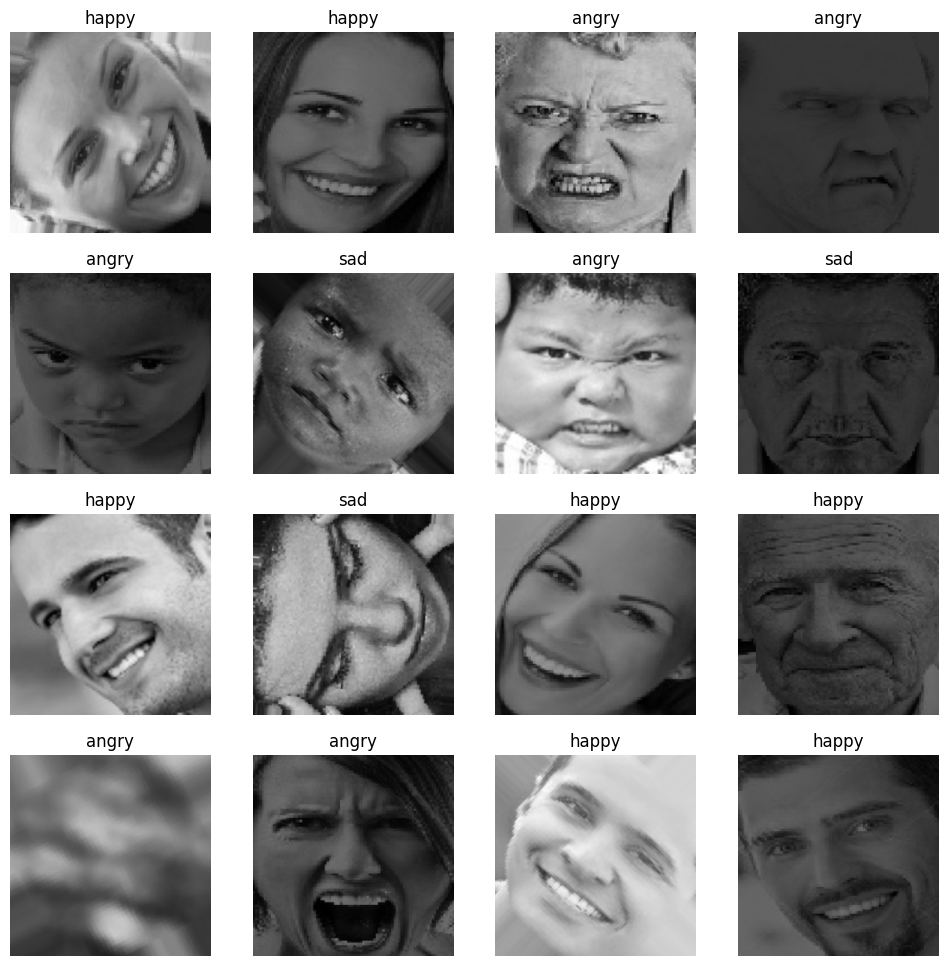

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

## Data Augmentation

In [118]:
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomContrast

augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])

In [119]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

## Dataset Preparation

In [120]:
# Load data into memory in Reading mode
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [121]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [122]:
# Add pre-proceesing as a layer in the model help in deployment process as you don't have to create seperate preprocessing module
from tensorflow.keras.layers import Resizing, Rescaling

resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

In [123]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [124]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

# Modeling

## Lenet

LeNet, short for LeNet-5, is a pioneering convolutional neural network (CNN) architecture designed by Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffner in 1998. It was one of the earliest CNN models and played a significant role in popularizing the use of neural networks in computer vision tasks, particularly for handwritten digit recognition.

The LeNet-5 architecture was initially developed for recognizing handwritten digits in images, such as the MNIST dataset, which contains images of handwritten digits from 0 to 9. It consists of seven layers, including three convolutional layers, two average pooling layers, and two fully connected layers. Here's a brief overview of the architecture:



1.   Input Layer: Accepts the input grayscale image (usually 32x32 pixels for LeNet-5) representing a handwritten digit.
2.   Convolutional Layer 1: The first convolutional layer applies several learned filters to the input image to extract local features. It uses a small receptive field and has a few feature maps.

3.  Average Pooling Layer 1: After each convolutional layer, there is an average pooling layer that performs downsampling, reducing the spatial dimensions while retaining important features.

4.   Convolutional Layer 2: Similar to the first convolutional layer, it further extracts higher-level features from the output of the previous pooling layer.

5.   Average Pooling Layer 2: Another pooling layer to reduce dimensions further.

6.   Fully Connected Layer 1: This layer connects every neuron from the previous layer to each neuron, making it fully connected. It acts as a classifier and performs high-level feature processing.

7.   Fully Connected Layer 2 (Output Layer): The final fully connected layer produces the output logits for each class (0 to 9 for MNIST) and is usually followed by a softmax activation function to generate the probabilities for each class.

LeNet-5 was trained using gradient-based optimization algorithms like Stochastic Gradient Descent (SGD) and was groundbreaking at the time for its successful application in digit recognition tasks. However, with the advent of more powerful GPUs, larger datasets, and deeper architectures, LeNet-5 has been largely surpassed by more advanced CNN models like VGG, ResNet, and various modern architectures used in deep learning today. Nonetheless, LeNet-5 remains an important milestone in the history of deep learning and CNNs.

  Note: To understand how softmax work refer [here](https://www.analyticsvidhya.com/blog/2021/04/introduction-to-softmax-for-neural-network/)

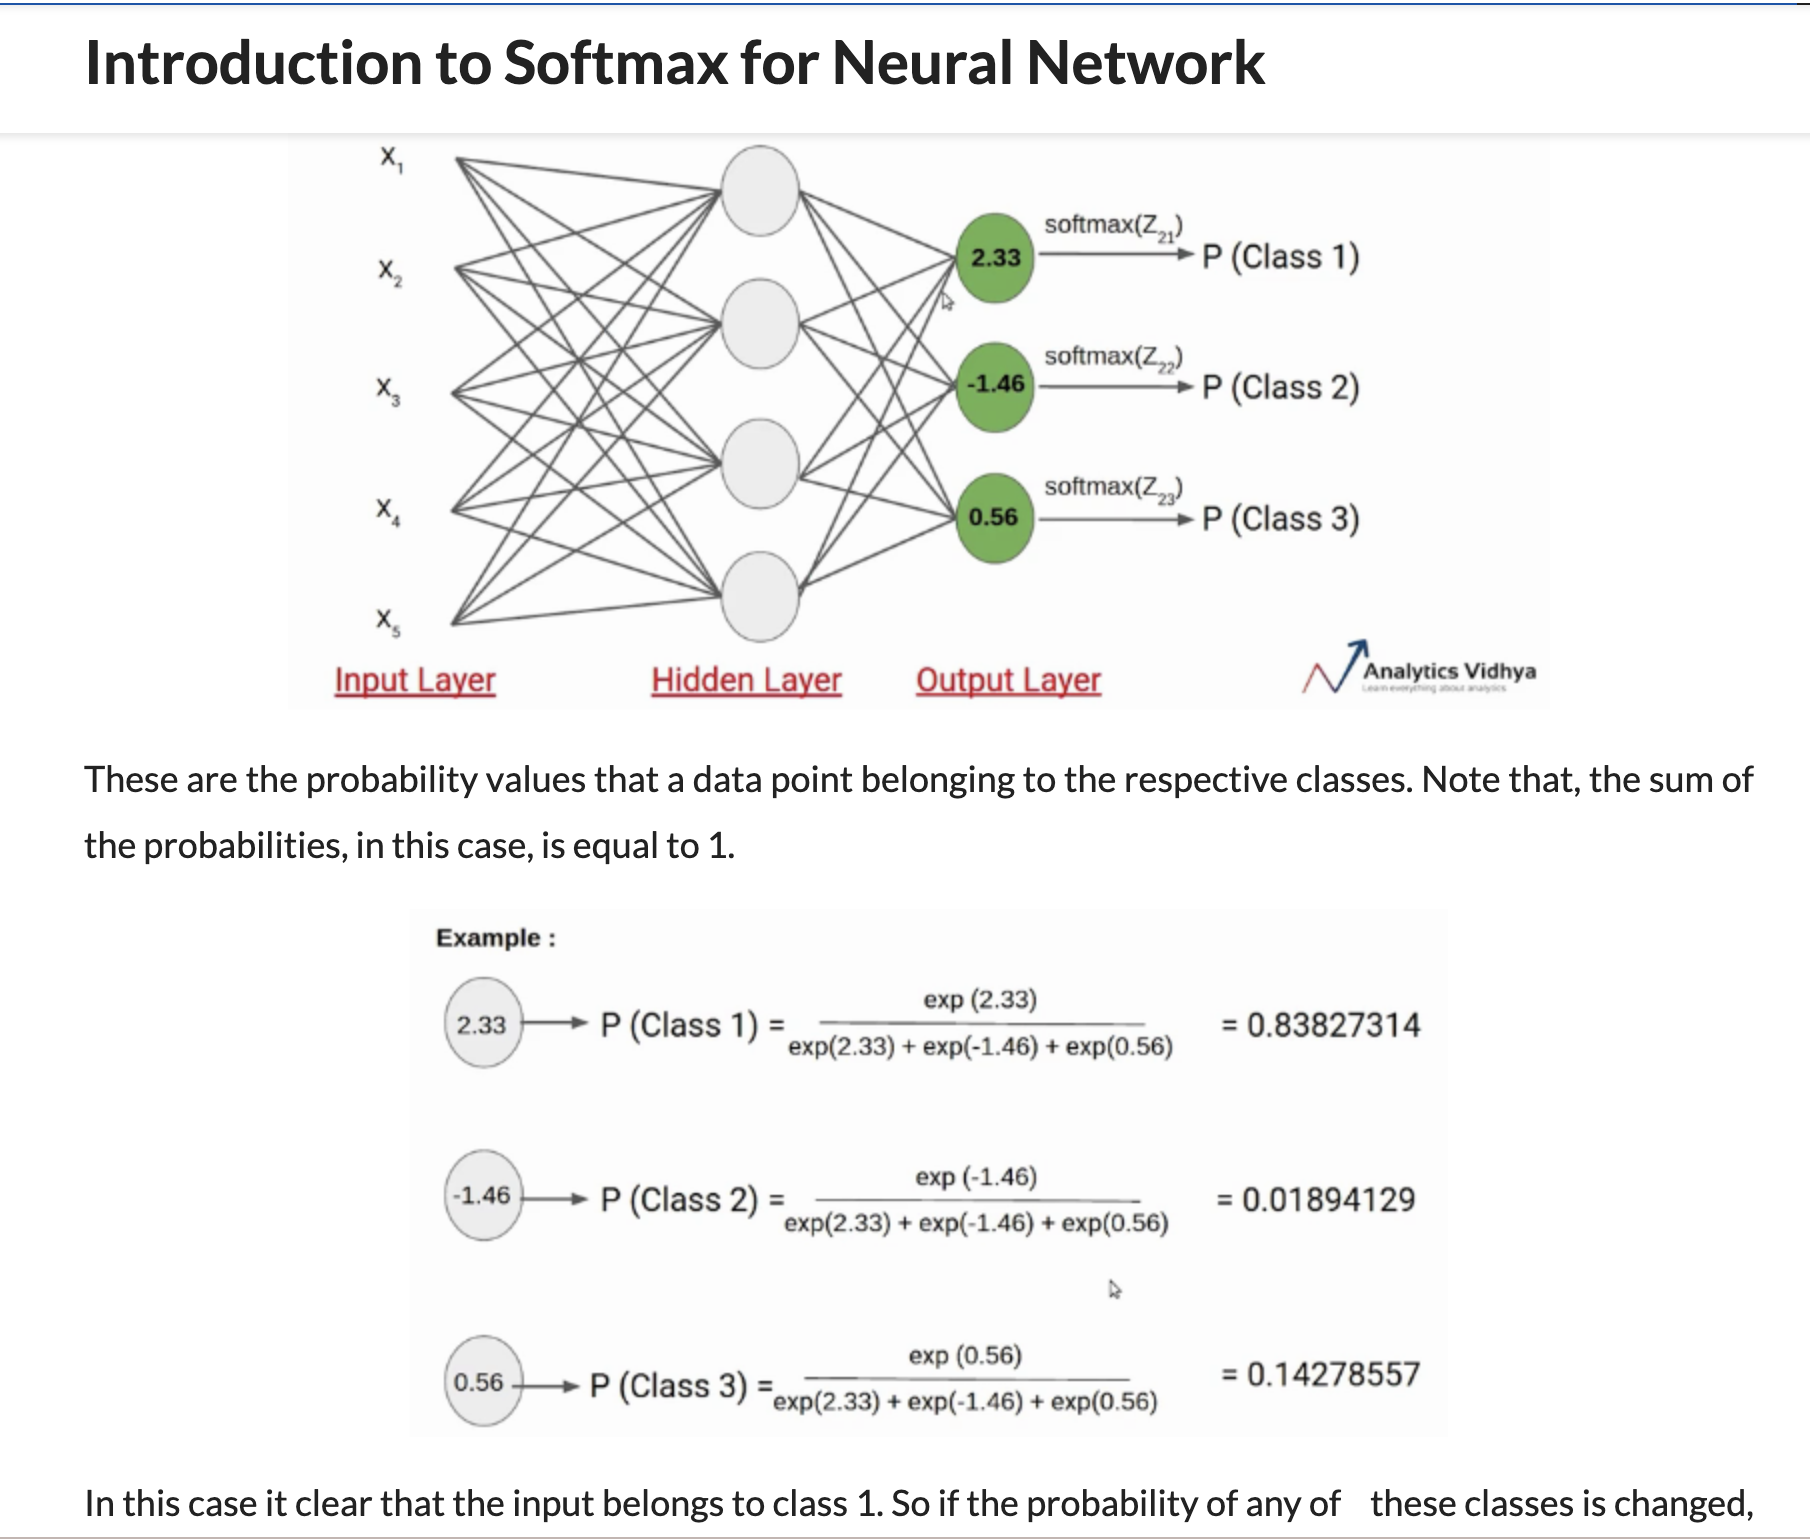

In [54]:
# To understand Soft-max

from IPython import display
display.Image("/content/content/MyDrive/Master/Deep learning/Tensor flow/Deep Learning Master Class with Tensor flow2/Section12/Screenshot 2023-07-23 at 2.58.42 PM.png")

In [129]:
from tensorflow.keras.layers import (Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense, Flatten, InputLayer,
                                     BatchNormalization, Input, Embedding, Permute, Dropout, LayerNormalization,
                                     MultiHeadAttention, Reshape)

from tensorflow.keras.regularizers  import L2, L1

lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    # downsampling
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    # downsampling
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_28 (Bat  (None, 254, 254, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 127, 127, 6)      0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 127, 127, 6)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 125, 125, 16)    

# Training

## Class Weighting

In [59]:
import os

n_sample_path = "/content/content/MyDrive/Master/Deep learning/Tensor flow/Deep Learning Master Class with Tensor flow2/Section12/Emotions Dataset/Emotions Dataset/train/"
n_sample_0 = len(os.listdir(n_sample_path + "angry")) # angry
n_sample_1 = len(os.listdir(n_sample_path + "happy")) # happy
n_sample_2 = len(os.listdir(n_sample_path + "sad")) # sad


In [61]:
number_of_samples = n_sample_0 + n_sample_1 + n_sample_2

In [71]:
class_weights = {0: n_sample_0/number_of_samples, 1: n_sample_1/number_of_samples, 2: n_sample_2/number_of_samples}

In [65]:
print(class_weights)

{'angry': 0.22429769083688778, 'happy': 0.4440358876305339, 'sad': 0.3316664215325783}


## Train

In [112]:
# It means that the model produce logit tensor which means that sum of probability of output is equal 1.
# The perfect value for loss is near zero

loss_function = CategoricalCrossentropy()

# Use SparseCategorical when the y_true looks like [1,2] but y_pred looks like [[0.1, 0.9 , 0.0], [0.0, 0.9 , 0.1]]
# loss_function = SparseCategoricalCrossentropy(from_logits=False)


In [113]:
# if any of top k matches predicted value count it as a one
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [130]:
from tensorflow.keras.optimizers import Adam

lenet_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [80]:
history = lenet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  class_weight = class_weights
)

Epoch 1/20
 59/213 [=======>......................] - ETA: 39s - loss: 0.4078 - accuracy: 0.4229 - top_k_accuracy: 0.7669

KeyboardInterrupt: ignored

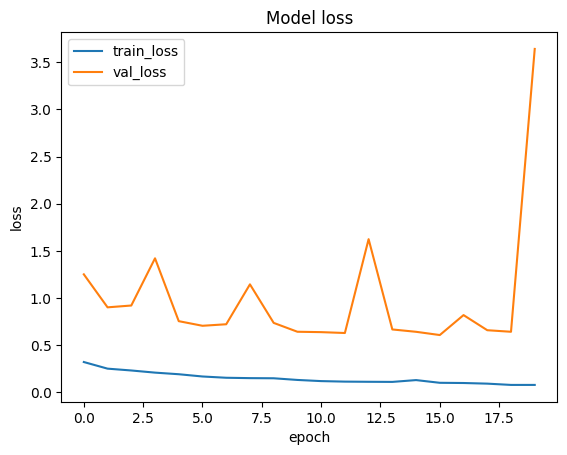

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

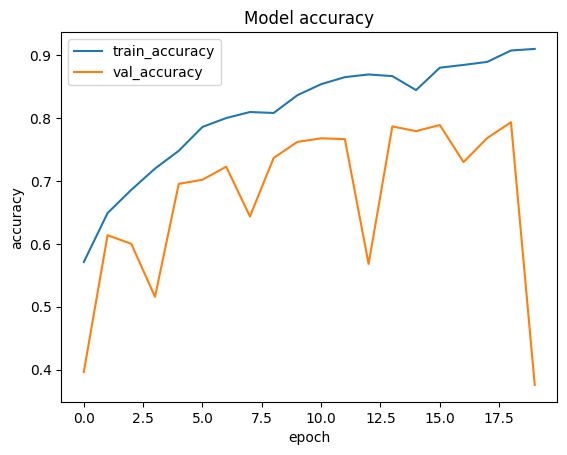

In [74]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

The model is over fitting as we can see from val loss


Let's retrain after adjust dropout from 0 to 0.2


In [ ]:
history = lenet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  class_weight = class_weights
)

Epoch 1/20
213/213 [==============================] - 85s 392ms/step - loss: 0.3047 - accuracy: 0.5618 - top_k_accuracy: 0.8317 - val_loss: 1.2122 - val_accuracy: 0.4456 - val_top_k_accuracy: 0.7739
Epoch 2/20
213/213 [==============================] - 71s 330ms/step - loss: 0.2730 - accuracy: 0.6164 - top_k_accuracy: 0.8584 - val_loss: 1.6631 - val_accuracy: 0.4421 - val_top_k_accuracy: 0.7752
Epoch 3/20
213/213 [==============================] - 71s 332ms/step - loss: 0.2727 - accuracy: 0.6132 - top_k_accuracy: 0.8628 - val_loss: 1.0095 - val_accuracy: 0.5768 - val_top_k_accuracy: 0.8169
Epoch 4/20
213/213 [==============================] - 70s 324ms/step - loss: 0.2546 - accuracy: 0.6495 - top_k_accuracy: 0.8691 - val_loss: 1.0540 - val_accuracy: 0.5742 - val_top_k_accuracy: 0.8608
Epoch 5/20
213/213 [==============================] - 68s 317ms/step - loss: 0.2411 - accuracy: 0.6722 - top_k_accuracy: 0.8866 - val_loss: 0.8965 - val_accuracy: 0.6462 - val_top_k_accuracy: 0.8714
Epoch

In [89]:
history = lenet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = 10,
  verbose = 1,
  class_weight = class_weights
)

Epoch 1/10
213/213 [==============================] - 92s 419ms/step - loss: 0.0699 - accuracy: 0.9185 - top_k_accuracy: 0.9835 - val_loss: 0.7702 - val_accuracy: 0.7682 - val_top_k_accuracy: 0.9201
Epoch 2/10
213/213 [==============================] - 73s 338ms/step - loss: 0.0753 - accuracy: 0.9112 - top_k_accuracy: 0.9824 - val_loss: 0.6967 - val_accuracy: 0.7792 - val_top_k_accuracy: 0.9302
Epoch 3/10
213/213 [==============================] - 73s 341ms/step - loss: 0.0705 - accuracy: 0.9103 - top_k_accuracy: 0.9850 - val_loss: 0.7384 - val_accuracy: 0.7818 - val_top_k_accuracy: 0.9236
Epoch 4/10
213/213 [==============================] - 71s 330ms/step - loss: 0.0585 - accuracy: 0.9304 - top_k_accuracy: 0.9894 - val_loss: 0.7634 - val_accuracy: 0.7537 - val_top_k_accuracy: 0.9157
Epoch 5/10
213/213 [==============================] - 71s 329ms/step - loss: 0.0627 - accuracy: 0.9253 - top_k_accuracy: 0.9874 - val_loss: 0.7092 - val_accuracy: 0.7888 - val_top_k_accuracy: 0.9342
Epoch

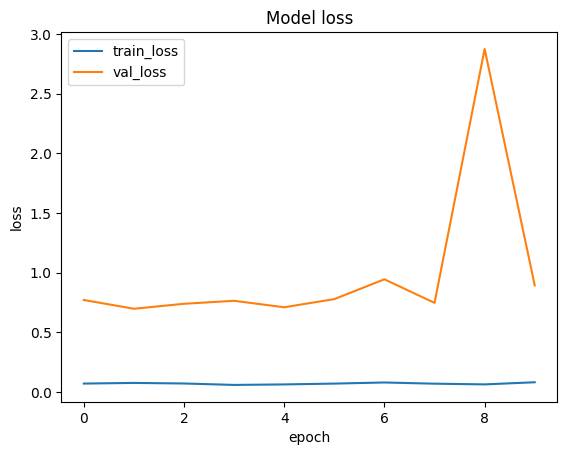

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

Better right?

but let's see the effect of regularization rerun the notebook after changing regularization rate to 0.0001
its range is from 0 to 0.1
Note Trying put it as 0.1 may cause the model to underfit cause it penalize the weights too much it basically can not learn anything.

In [131]:
history = lenet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  class_weight = class_weights
)

Epoch 1/20
213/213 [==============================] - 84s 370ms/step - loss: 1.8852 - accuracy: 0.5128 - top_k_accuracy: 0.7916 - val_loss: 1.6939 - val_accuracy: 0.4416 - val_top_k_accuracy: 0.7739
Epoch 2/20
213/213 [==============================] - 71s 329ms/step - loss: 0.9627 - accuracy: 0.5461 - top_k_accuracy: 0.8234 - val_loss: 1.8424 - val_accuracy: 0.4412 - val_top_k_accuracy: 0.7739
Epoch 3/20
213/213 [==============================] - 73s 340ms/step - loss: 1.1420 - accuracy: 0.5496 - top_k_accuracy: 0.8245 - val_loss: 1.8901 - val_accuracy: 0.5206 - val_top_k_accuracy: 0.7853
Epoch 4/20
213/213 [==============================] - 71s 331ms/step - loss: 1.0470 - accuracy: 0.5727 - top_k_accuracy: 0.8360 - val_loss: 1.5783 - val_accuracy: 0.5092 - val_top_k_accuracy: 0.8060
Epoch 5/20
213/213 [==============================] - 72s 333ms/step - loss: 0.8880 - accuracy: 0.5757 - top_k_accuracy: 0.8395 - val_loss: 1.5800 - val_accuracy: 0.5413 - val_top_k_accuracy: 0.8349
Epoch

In [133]:
history = lenet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  class_weight = class_weights
)

Epoch 1/20
213/213 [==============================] - 81s 377ms/step - loss: 0.7116 - accuracy: 0.6745 - top_k_accuracy: 0.8822 - val_loss: 1.2227 - val_accuracy: 0.6659 - val_top_k_accuracy: 0.8731
Epoch 2/20
213/213 [==============================] - 71s 331ms/step - loss: 0.7209 - accuracy: 0.6857 - top_k_accuracy: 0.8885 - val_loss: 1.2276 - val_accuracy: 0.6585 - val_top_k_accuracy: 0.8613
Epoch 3/20
213/213 [==============================] - 82s 384ms/step - loss: 0.6929 - accuracy: 0.6883 - top_k_accuracy: 0.8779 - val_loss: 1.2838 - val_accuracy: 0.6273 - val_top_k_accuracy: 0.8683
Epoch 4/20
213/213 [==============================] - 70s 324ms/step - loss: 0.6873 - accuracy: 0.6777 - top_k_accuracy: 0.8853 - val_loss: 1.1977 - val_accuracy: 0.6752 - val_top_k_accuracy: 0.8727
Epoch 5/20
213/213 [==============================] - 72s 335ms/step - loss: 0.6688 - accuracy: 0.6872 - top_k_accuracy: 0.8887 - val_loss: 1.1549 - val_accuracy: 0.6918 - val_top_k_accuracy: 0.8859
Epoch

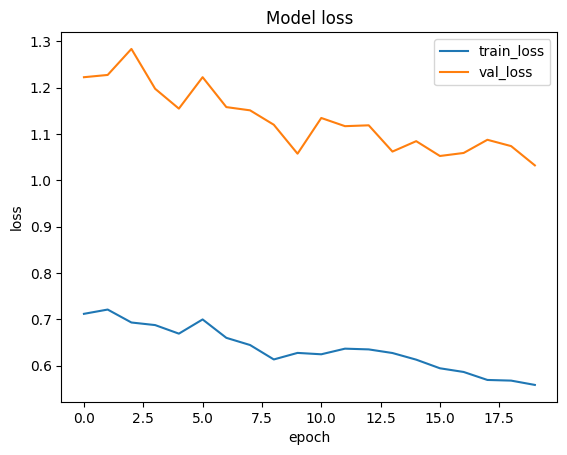

In [134]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

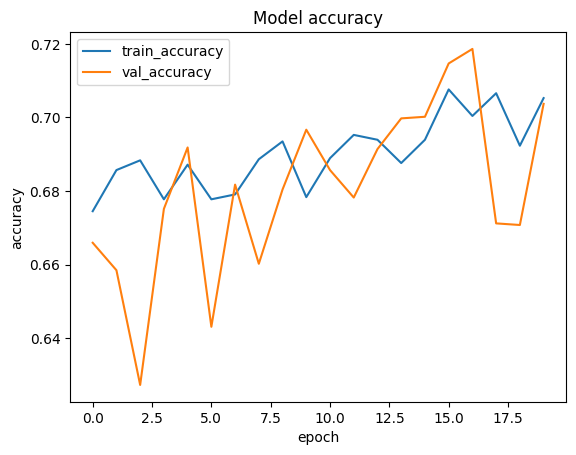

In [135]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [136]:
# let's try another 20

history = lenet_model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  class_weight = class_weights
)

Epoch 1/20
213/213 [==============================] - 80s 369ms/step - loss: 0.5394 - accuracy: 0.6985 - top_k_accuracy: 0.8919 - val_loss: 1.0092 - val_accuracy: 0.7142 - val_top_k_accuracy: 0.9047
Epoch 2/20
213/213 [==============================] - 78s 362ms/step - loss: 0.5254 - accuracy: 0.7129 - top_k_accuracy: 0.9001 - val_loss: 1.0136 - val_accuracy: 0.7041 - val_top_k_accuracy: 0.8938
Epoch 3/20
213/213 [==============================] - 70s 326ms/step - loss: 0.5535 - accuracy: 0.7004 - top_k_accuracy: 0.8934 - val_loss: 0.9963 - val_accuracy: 0.7011 - val_top_k_accuracy: 0.8951
Epoch 4/20
213/213 [==============================] - 70s 326ms/step - loss: 0.5183 - accuracy: 0.7208 - top_k_accuracy: 0.8969 - val_loss: 0.9564 - val_accuracy: 0.7133 - val_top_k_accuracy: 0.9074
Epoch 5/20
213/213 [==============================] - 70s 325ms/step - loss: 0.5215 - accuracy: 0.7089 - top_k_accuracy: 0.9018 - val_loss: 1.0320 - val_accuracy: 0.7050 - val_top_k_accuracy: 0.8982
Epoch

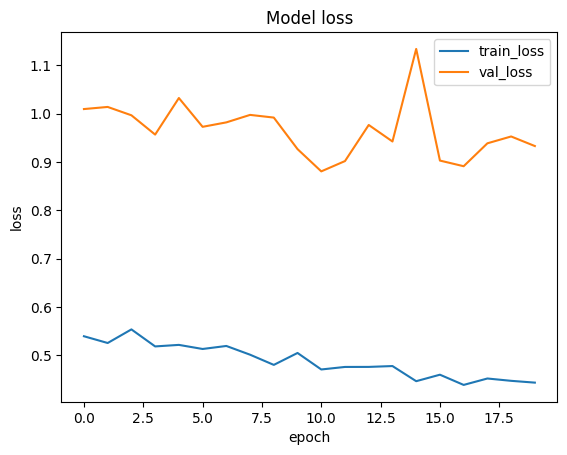

In [137]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

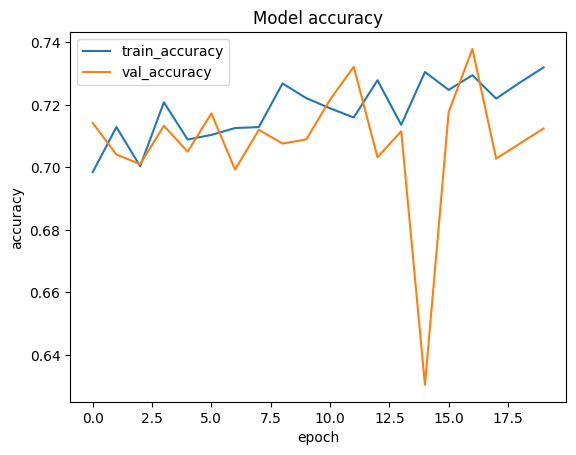

In [138]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

So clearly we have a more stable model with train and validation accuracy that are quite similar

that was due to
- increase drop out rate.
- augment data.
- Add Regularization facor l2 which basically put a penality on the weights so it does not get higher and then overfit the data.
you can read more about Regularization [here](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c).

# Evaluation

In [139]:
lenet_model.evaluate(validation_dataset)

2278/2278 [==============================] - 15s 7ms/step - loss: 0.9327 - accuracy: 0.7125 - top_k_accuracy: 0.8903


[0.9327214956283569, 0.7124670743942261, 0.8902546167373657]

# Testing

In [170]:
images = []
labels = []

In [171]:
for image,label in validation_dataset.take(20):
  images.append(image)
  labels.append(label)

In [172]:
images[6][0].shape

TensorShape([256, 256, 3])

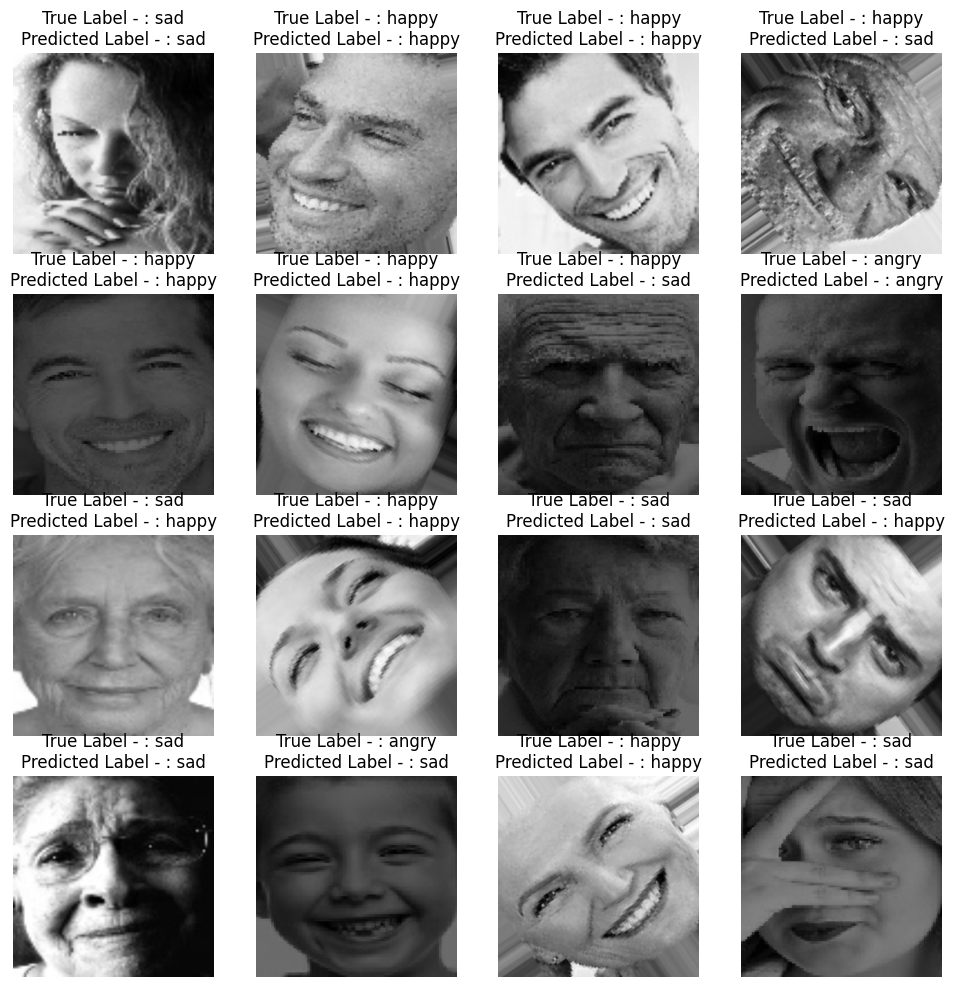

In [173]:
plt.figure(figsize = (12,12))

for i in range(16):
  ax = plt.subplot(4,4, i+1)
  plt.imshow(images[i][0]/255.)

  plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i][0], axis = -1).numpy()]
            + "\n" + "Predicted Label - : "
            + CONFIGURATION["CLASS_NAMES"][int(tf.argmax(lenet_model(tf.expand_dims(images[i][0], axis = 0)), axis =-1).numpy()[0])] )
  plt.axis("off")

## Confusion Matrix

In [174]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [ ]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 1 2 ... 2 1 0]
[1 1 2 ... 2 1 0]


In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[397  48  70]
 [ 27 909  70]
 [ 61  87 609]]


Text(0.5, 51.0, 'Predicted')

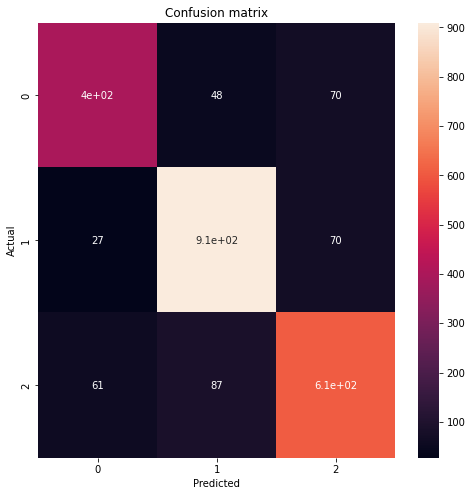

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')